In [ ]:
!pip install "tensorflow<2.11"

In [ ]:
!pip install opencv-python matplotlib seaborn panda numpy sklearn

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
from sklearn.model_selection import train_test_split

## Set up GPU for faster training

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## About the dataset
<p>HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions.</p> 
<p>The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.</p>

It has 7 different classes of skin cancer which are listed below:

- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma

In [9]:
# Read metadata
df = pd.read_csv('./skin-cancer-mnist/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [10]:
# Fill null age in csv file with mean value of age
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [11]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [19]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_dir = '.\skin-cancer-mnist'

# Merge images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [28]:
# Cell type index
# 0 - Actinic keratoses	
# 1 - Basal cell carcinoma
# 2 - Benign keratosis-like lesions
# 3 - Dermatofibroma	
# 4 - Melanocytic nevi
# 5 - Melanoma
# 6 - Vascular lesions
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\skin-cancer-mnist\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\skin-cancer-mnist\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\skin-cancer-mnist\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\skin-cancer-mnist\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\skin-cancer-mnist\HAM10000_images_part_2\ISI...,Benign keratosis-like lesions,2,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [29]:
# Resize Image
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

In [ ]:
# Code to show some sample images and save it
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [31]:
# See the image size distribution - should just return one row (all images are uniform)
df['image'].map(lambda x: x.shape).value_counts()

image
(100, 125, 3)    10015
Name: count, dtype: int64

## Data Analysis

<Axes: title={'center': 'CELL TYPE'}, xlabel='cell_type', ylabel='Count'>

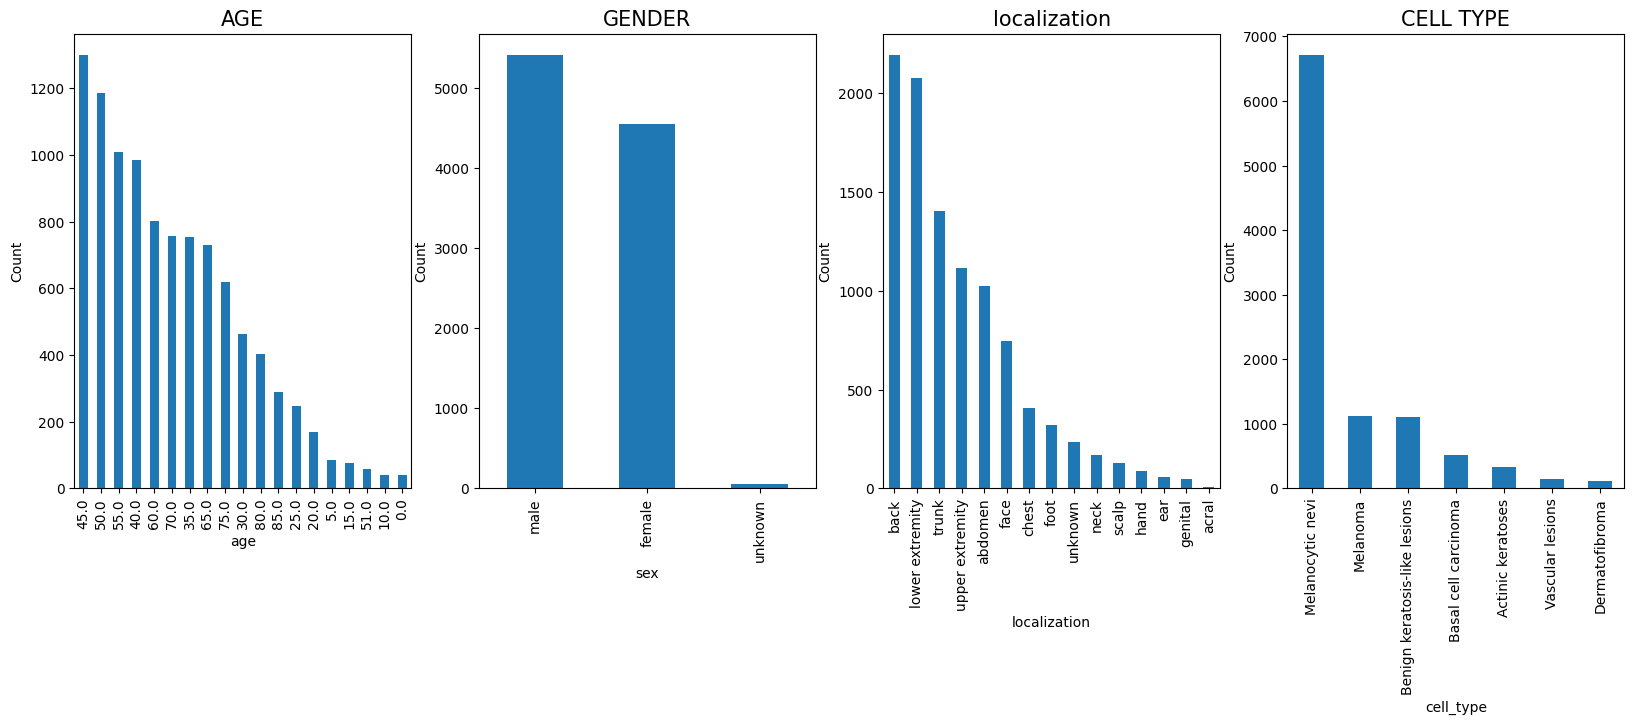

In [32]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

In [33]:
# Data feature and labels
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [34]:
target.head()

0    2
1    2
2    2
3    2
4    2
Name: cell_type_idx, dtype: int8

In [35]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0])>)

## Data Extraction

In [36]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [37]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

# Data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

# Training step
## CNN
I choose CNN for image classification

In [60]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential

In [85]:
input_shape = (100, 125, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(64, (3, 3), 1, activation='relu', padding = 'Same', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), 1, activation='relu', padding = 'Same'))
model.add(MaxPool2D())

model.add(Conv2D(64, (3, 3), 1, activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), 1, activation='relu', padding = 'Same'))
model.add(MaxPool2D())

model.add(Conv2D(64, (3, 3), 1, activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), 1, activation='relu',padding = 'Same'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 100, 125, 64)      1792      
                                                                 
 conv2d_78 (Conv2D)          (None, 100, 125, 64)      36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 50, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 50, 62, 64)        36928     
                                                                 
 conv2d_80 (Conv2D)          (None, 50, 62, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 25, 31, 64)       0         
 g2D)                                                

In [86]:
# Define the optimizer
optimizer = Adam()
# Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [87]:
# Train model
epochs = 60
batch_size = 16
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate, y_validate),
                              verbose = 1, callbacks=[learning_rate_reduction])

Epoch 1/60
423/423 [==============================] - 11s 24ms/step - loss: 1.0291 - accuracy: 0.6655 - val_loss: 1.0298 - val_accuracy: 0.6410 - lr: 0.0010
Epoch 2/60
423/423 [==============================] - 10s 23ms/step - loss: 0.9261 - accuracy: 0.6727 - val_loss: 0.9508 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 3/60
423/423 [==============================] - 10s 23ms/step - loss: 0.8962 - accuracy: 0.6821 - val_loss: 0.9053 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 4/60
423/423 [==============================] - 10s 23ms/step - loss: 0.8717 - accuracy: 0.6911 - val_loss: 0.8592 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 5/60
423/423 [==============================] - 10s 24ms/step - loss: 0.8395 - accuracy: 0.6970 - val_loss: 0.8343 - val_accuracy: 0.7021 - lr: 0.0010
Epoch 6/60
423/423 [==============================] - 10s 24ms/step - loss: 0.8336 - accuracy: 0.7097 - val_loss: 0.8779 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 7/60
423/423 [==============================] - 10s 

## Evaluate Performance

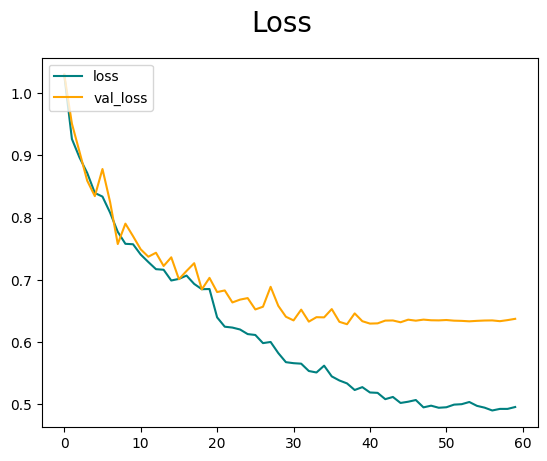

In [88]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

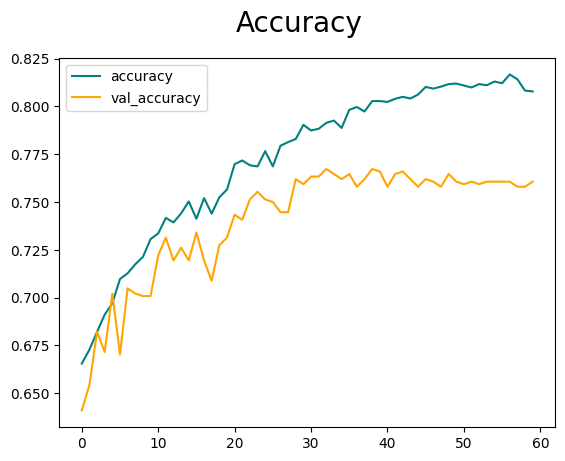

In [89]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [90]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [91]:
# Show metrics and save model
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

24/24 [==============================] - 0s 7ms/step - loss: 0.6372 - accuracy: 0.7606
Validation: accuracy = 0.760638  ;  loss_v = 0.637224
Test: accuracy = 0.766773  ;  loss = 0.641329


24/24 [==============================] - 0s 6ms/step


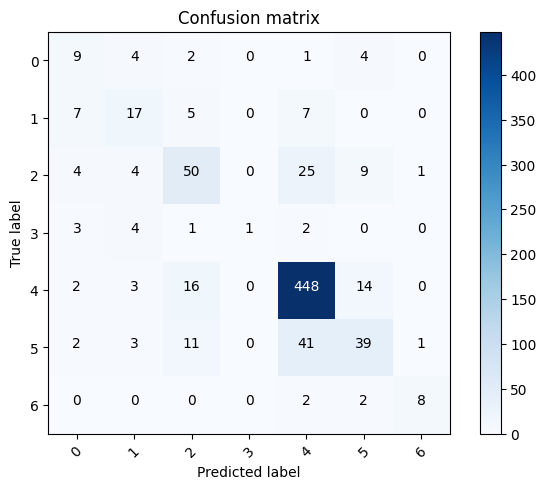

In [92]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

79/79 [==============================] - 1s 9ms/step


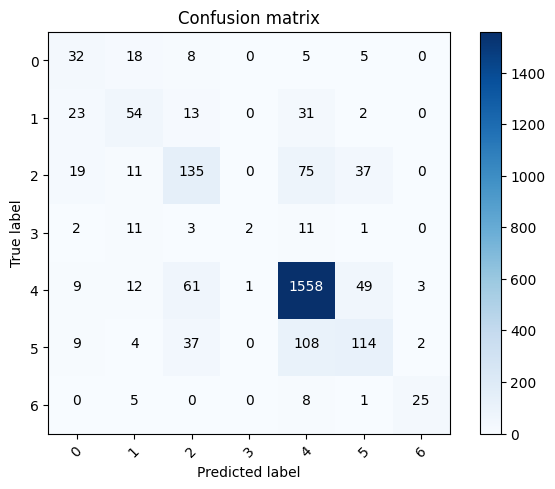

In [93]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

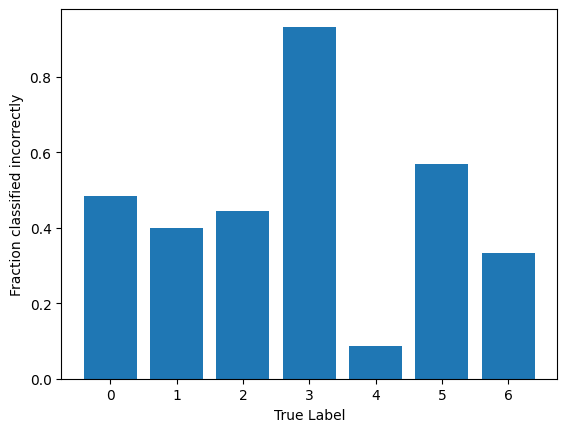

In [77]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

NameError: name 'y_test' is not defined